### import required packages

In [1]:
import os, glob
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
PandasTools.InstallPandasTools()
import ast

pd.options.mode.chained_assignment = None

In [2]:
import rdkit

print(rdkit.__version__)

2023.09.5


In [3]:
from rdkit import rdBase

# Suppress RDKit warnings and running information
rdBase.DisableLog('rdApp.warning')  # Disable warnings
rdBase.DisableLog('rdApp.info')  # Disable info messages

In [4]:
import sys
sys.path.append('../')

from src.utils.mol_utils import (
    get_inchi_noStereo_from_smi,
    get_inchi_noStereo_from_mol,
    preprocess,
    element_label,
    get_MW,
    get_smi_noStereo_from_mol,
    get_smi_noStereo_from_smi,
)

from src.features.physicochem_properties_for_pca import get_physicochemical_properties

In [5]:
pd.set_option('display.max_rows', 20)

# load data sets

## load annotated AZ public data

In [6]:
az_public_df = pd.read_csv('../data/az_shared_MetID/120_compounds_with_SoM_annotations.csv')
len(az_public_df)

120

In [7]:
az_public_df.Comment.value_counts()

Comment
mol has at least one exact SoM                                      95
mol not annotated due to ambiguity in experimental data             11
mol has only extended SoMs                                          10
mol is metabolically stable in the specific experimental setting     4
Name: count, dtype: int64

In [8]:
az_public_df = az_public_df[az_public_df.Comment.isin(['mol has at least one exact SoM','mol is metabolically stable in the specific experimental setting'])]
len(az_public_df)

99

In [9]:
az_public_df.columns

Index(['Compound ID', 'SMILES',
       'SoMs grouped (numbers provided are atom indices)',
       'Exact SoM annotation (1) or extended SoM annotation (0) per group',
       'Comment'],
      dtype='object')

In [10]:
az_public_df = az_public_df.rename(columns={
    'Compound ID': 'mol_id',
    'SMILES': 'preprocessed_smi',
    'SoMs grouped (numbers provided are atom indices)': 'soms',
    'Exact SoM annotation (1) or extended SoM annotation (0) per group': 'certain'
})
az_public_df.columns


Index(['mol_id', 'preprocessed_smi', 'soms', 'certain', 'Comment'], dtype='object')

## load and preprocess approved drugs

In [11]:
drugs_df = PandasTools.LoadSDF('../data/drugbank_approveddrugs/approveddrugs_structures.sdf',removeHs=False)
len(drugs_df)

[17:36:46] Explicit valence for atom # 28 N, 4, is greater than permitted
[17:36:46] ERROR: Could not sanitize molecule ending on line 327071
[17:36:46] ERROR: Explicit valence for atom # 28 N, 4, is greater than permitted


2618

In [12]:
drugs_df.columns

Index(['DATABASE_ID', 'DATABASE_NAME', 'SMILES', 'INCHI_IDENTIFIER',
       'INCHI_KEY', 'FORMULA', 'MOLECULAR_WEIGHT', 'EXACT_MASS',
       'JCHEM_ACCEPTOR_COUNT', 'JCHEM_ATOM_COUNT',
       'JCHEM_AVERAGE_NEUTRAL_MICROSPECIES_CHARGE',
       'JCHEM_AVERAGE_POLARIZABILITY', 'JCHEM_BIOAVAILABILITY',
       'JCHEM_DONOR_COUNT', 'JCHEM_FORMAL_CHARGE', 'JCHEM_GHOSE_FILTER',
       'JCHEM_IUPAC', 'ALOGPS_LOGP', 'JCHEM_LOGP', 'ALOGPS_LOGS',
       'JCHEM_MDDR_LIKE_RULE', 'JCHEM_NEUTRAL_CHARGE', 'JCHEM_NUMBER_OF_RINGS',
       'JCHEM_PHYSIOLOGICAL_CHARGE', 'JCHEM_PKA', 'JCHEM_PKA_STRONGEST_ACIDIC',
       'JCHEM_PKA_STRONGEST_BASIC', 'JCHEM_POLAR_SURFACE_AREA',
       'JCHEM_REFRACTIVITY', 'JCHEM_ROTATABLE_BOND_COUNT',
       'JCHEM_RULE_OF_FIVE', 'ALOGPS_SOLUBILITY', 'JCHEM_TRADITIONAL_IUPAC',
       'JCHEM_VEBER_RULE', 'DRUGBANK_ID', 'SECONDARY_ACCESSION_NUMBERS',
       'DRUG_GROUPS', 'GENERIC_NAME', 'SYNONYMS', 'PRODUCTS',
       'INTERNATIONAL_BRANDS', 'ID', 'ROMol', 'SALTS'],
      dty

In [13]:
drugs_df['preprocessed_mol'] = drugs_df['ROMol'].map(preprocess)
print(f'Dataframe was of lenth {len(drugs_df)}.')

drugs_df['element_label'] = drugs_df['preprocessed_mol'].apply(element_label)
drugs_df = drugs_df[drugs_df.element_label == 1]

print(f'Dataframe after element filter is now of lenth {len(drugs_df)}.')

Dataframe was of lenth 2618.
Dataframe after element filter is now of lenth 2394.


In [14]:
print(f'Dataframe was of lenth {len(drugs_df)}.')

drugs_df['MW'] = drugs_df['preprocessed_mol'].map(get_MW)
drugs_df = drugs_df[drugs_df['MW'].between(100,1000)]
drugs_df.reset_index(drop=True, inplace=True)

print(f'Dataframe after molecular weight filter is now of lenth {len(drugs_df)}.')

Dataframe was of lenth 2394.
Dataframe after molecular weight filter is now of lenth 2252.


# Compounds comparison (AZ Compounds, Approved Drugs)

## Overlap

### get inchi without stereochemistry

In [15]:
# get inchi without stereochemistry
az_public_df['inchi_noStereo'] = az_public_df['preprocessed_smi'].map(get_inchi_noStereo_from_smi)
drugs_df['inchi_noStereo'] = drugs_df['preprocessed_mol'].map(get_inchi_noStereo_from_mol)

In [16]:
pd.merge(az_public_df, drugs_df, how ='inner', on=['inchi_noStereo'])

,mol_id,preprocessed_smi,soms,certain,Comment,inchi_noStereo,DATABASE_ID,DATABASE_NAME,SMILES,INCHI_IDENTIFIER,...,GENERIC_NAME,SYNONYMS,PRODUCTS,INTERNATIONAL_BRANDS,ID,ROMol,SALTS,preprocessed_mol,element_label,MW
0,Cmpd 4,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...,"['42', '18', '7,8']","['1', '1', '0']",mol has at least one exact SoM,InChI=1S/C47H51NO14/c1-25-31(60-43(56)36(52)35...,DB01229,drugbank,[H][C@]12[C@H](OC(=O)C3=CC=CC=C3)[C@]3(O)C[C@H...,InChI=1S/C47H51NO14/c1-25-31(60-43(56)36(52)35...,...,Paclitaxel,"5beta,20-Epoxy-1,2-alpha,4,7beta,10beta,13alph...",Abraxane; Abraxane for Injectable Suspension; ...,Paxceed,,<rdkit.Chem.rdchem.Mol object at 0x7fa6e0aabf40>,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa6e0144ac0>,1,853.918
1,Cmpd 111,CCOc1ncc(C)c2c1[C@H](c1ccc(C#N)cc1OC)C(C(N)=O)...,"['21,25', '10,27']","['1', '1']",mol has at least one exact SoM,InChI=1S/C21H22N4O3/c1-5-28-21-18-17(14-7-6-13...,DB16165,drugbank,CCOC1=NC=C(C)C2=C1[C@H](C1=CC=C(C=C1OC)C#N)C(C...,InChI=1S/C21H22N4O3/c1-5-28-21-18-17(14-7-6-13...,...,Finerenone,Finerenone,Kerendia,Kerendia,,<rdkit.Chem.rdchem.Mol object at 0x7fa6e02c9700>,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fa6e0172f10>,1,378.432
2,Cmpd 115,COc1ccc(CCO[C@@H]2CCCC[C@H]2N2CC[C@@H](O)C2)cc1OC,"['19', '0,24']","['1', '0']",mol has at least one exact SoM,InChI=1S/C20H31NO4/c1-23-19-8-7-15(13-20(19)24...,DB06217,drugbank,COC1=C(OC)C=C(CCO[C@@H]2CCCC[C@H]2N2CC[C@@H](O...,InChI=1S/C20H31NO4/c1-23-19-8-7-15(13-20(19)24...,...,Vernakalant,"(3R)-1-((1R,2R)-2-(2-(3,4-dimethoxyphenyl)etho...",Brinavess,Kynapid,,<rdkit.Chem.rdchem.Mol object at 0x7fa6e08f49e0>,Vernakalant hydrochloride,<rdkit.Chem.rdchem.Mol object at 0x7fa6e0152ea0>,1,349.471


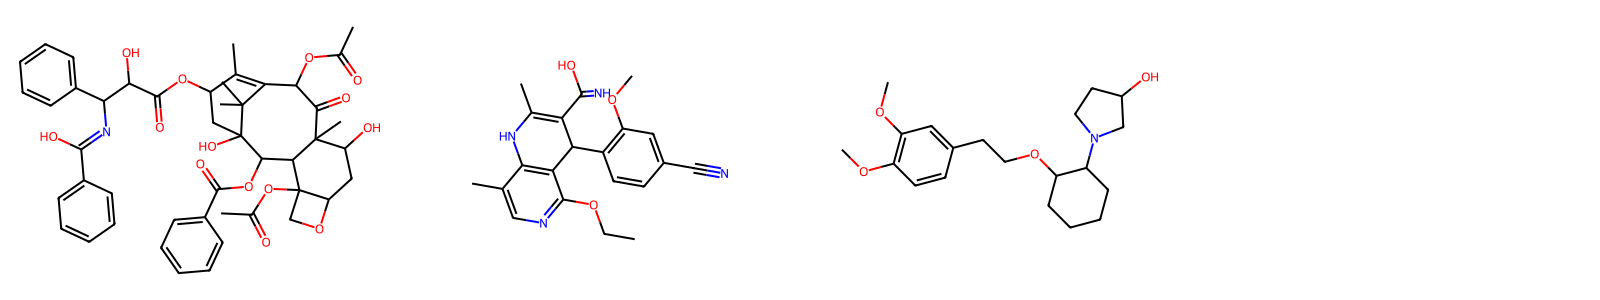

In [17]:
# visualize the overlap compound structures of az_public_df and drugs_df
overlap_az_drugs = pd.merge(az_public_df, drugs_df, how ='inner', on=['inchi_noStereo'])
Draw.MolsToGridImage([Chem.MolFromInchi(inchi) for inchi in overlap_az_drugs['inchi_noStereo']], molsPerRow=4, subImgSize=(400,300))


In [18]:
drugs_df = drugs_df.drop_duplicates('inchi_noStereo')
len(drugs_df)

2179

In [19]:
drugs_df['mol_id'] = drugs_df['DATABASE_ID']

In [20]:
drugs_df['preprocessed_smi'] = drugs_df['preprocessed_mol'].map(Chem.MolToSmiles)

In [21]:
drugs_df[['mol_id','preprocessed_smi']].to_csv('../data/drugbank_approveddrugs/drugs_id_smi.csv',index=False)

In [22]:
az_public_df.drop_duplicates(subset=['inchi_noStereo'],inplace=True)
az_public_df[['mol_id','preprocessed_smi']].to_csv('../data/az_shared_MetID/az_sharedMetID_annotation_cleaned_id_smi.csv',index=False)

In [23]:
print(len(az_public_df))

98


## Calculate descriptors

In [24]:
az_public_df['smi_noStereo'] = az_public_df['preprocessed_smi'].map(get_smi_noStereo_from_smi)
drugs_df['smi_noStereo'] = drugs_df['preprocessed_mol'].map(get_smi_noStereo_from_mol)

In [25]:
az_public_df['db'] = 'AZ Compounds'
drugs_df['db'] = 'Approved Drugs'

In [26]:
from src.features.physicochem_properties_for_pca import get_physicochemical_properties

for d in [az_public_df,drugs_df]:
    get_physicochemical_properties(d,'smi_noStereo')

Start calculating properties.
Start calculating properties.


In [27]:
az_public_df.describe()

,N,O,S,chiral,MW,heavy_atoms,numRings,frac_csp3,numAro,nHalogens,h_acc,h_don,logP,TPSA,MR
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.00000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,3.948980,3.285714,0.285714,1.193878,428.908143,30.561224,4.020408,0.375112,14.55102,0.775510,5.846939,1.571429,3.139082,91.198367,114.004469
std,1.480961,1.729072,0.592043,1.389639,86.111743,6.311610,1.218243,0.143176,4.79502,1.010569,2.116952,1.025449,0.993169,30.026845,23.028870
min,1.000000,0.000000,0.000000,0.000000,249.317000,19.000000,2.000000,0.040000,6.00000,0.000000,3.000000,0.000000,1.440000,32.780000,74.940000
25%,3.000000,2.000000,0.000000,0.000000,371.676750,25.250000,3.000000,0.281500,12.00000,0.000000,4.000000,1.000000,2.448750,73.077500,97.014000
50%,4.000000,3.000000,0.000000,1.000000,427.400500,31.000000,4.000000,0.391000,16.00000,0.000000,6.000000,1.000000,2.991000,93.700000,114.178000
75%,5.000000,4.750000,0.000000,2.000000,476.533000,35.000000,5.000000,0.444000,17.00000,1.000000,7.750000,2.000000,3.721000,107.612500,126.345500
max,9.000000,14.000000,2.000000,11.000000,853.918000,62.000000,7.000000,0.700000,28.00000,4.000000,14.000000,4.000000,6.163000,221.290000,217.690000


In [28]:
drugs_df.describe()

,element_label,MW,N,O,S,chiral,heavy_atoms,numRings,frac_csp3,numAro,nHalogens,h_acc,h_don,logP,TPSA,MR
count,2179.0,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000
mean,1.0,362.570393,2.269849,3.540156,0.288665,2.043598,25.069757,2.797614,0.456603,8.532354,0.584672,4.907297,1.953190,2.565978,82.363442,95.539865
std,0.0,155.057918,2.022750,2.885259,0.644048,3.161323,10.860696,1.723247,0.261133,6.606285,1.262064,3.098866,1.902251,2.563678,55.421262,40.694877
min,1.0,100.457000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.277000,0.000000,2.219000
25%,1.0,255.363000,1.000000,2.000000,0.000000,0.000000,18.000000,2.000000,0.273000,5.000000,0.000000,3.000000,1.000000,1.149000,43.370000,67.760500
50%,1.0,338.444000,2.000000,3.000000,0.000000,1.000000,23.000000,3.000000,0.429000,6.000000,0.000000,4.000000,2.000000,2.661000,74.570000,91.901000
75%,1.0,439.734000,3.000000,5.000000,0.000000,3.000000,31.000000,4.000000,0.629000,12.000000,1.000000,6.000000,3.000000,4.068500,106.970000,116.441500
max,1.0,994.208000,13.000000,23.000000,8.000000,26.000000,69.000000,11.000000,1.000000,44.000000,14.000000,21.000000,16.000000,18.471000,399.710000,277.667000


## UMAP

In [29]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [30]:
dataframe = pd.concat([drugs_df,az_public_df], ignore_index=True)
featureList = ['MW', 'N', 'O', 'chiral',
       'heavy_atoms', 'h_acc', 'h_don', 'logP', 'TPSA', 'numAro',
       'numRings', 'frac_csp3', 'S', 'nHalogens', 'MR']
len(featureList)

15

In [31]:
import numpy as np

# x = np.array(dataframe.loc[:, featureList].values.tolist()).astype(np.float16)
x = dataframe.loc[:, featureList].values
y = dataframe.loc[:, ['db']].values

x = StandardScaler().fit_transform(x)

In [32]:
import umap

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(x)
embedding.shape

/home/ychen/software/miniconda3/envs/az_som_py310/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2277, 2)

In [33]:
X_embeddedDF = pd.DataFrame(data=embedding, columns=['UMAP 1', 'UMAP 2'])

umapDF = pd.concat([X_embeddedDF, dataframe[['db']], dataframe[['smi_noStereo']], dataframe[['mol_id']]], axis=1)

In [34]:
# First check the range of your UMAP coordinates
print("X range:", umapDF['UMAP 1'].min(), "to", umapDF['UMAP 1'].max())
print("Y range:", umapDF['UMAP 2'].min(), "to", umapDF['UMAP 2'].max())

X range: -1.2371909618377686 to 14.552547454833984
Y range: 0.12883900105953217 to 10.83377456665039


In [35]:
from src.utils.plot_utils import plot_umap

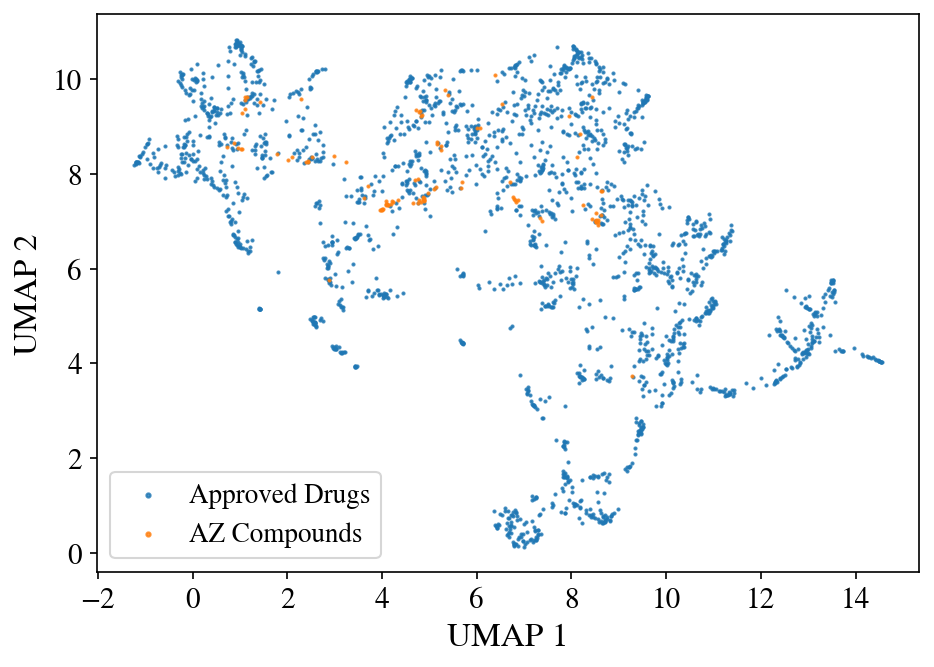

In [36]:
databases = ['Approved Drugs','AZ Compounds']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_umap(umapDF,databases,colors)

## distribution of properties

In [37]:
labelDict = {
    'N': 'Number of nitrogen atoms',
    'O': 'Number of oxygen atoms', 
    'chiral': 'Number of chiral centers',
    'MW': 'Molecular weight [DA]',
    'heavy_atoms': 'Number of heavy atoms',
    'h_acc': 'Number of hydrogen-bond acceptors',
    'h_don': 'Number of hydrogen-bond donors',
    'logP': 'logP (o/w)',
    'TPSA': 'Topological polar surface area',
    'numAro': 'Number of aromatic atoms',
    'formalCharge': 'Formal Charge',
    'numRings': 'Number of rings',
    'bridgeheadAtoms': 'Number of bridgehead atoms',
    'frac_csp3': 'Fraction of Csp3 atoms'
}

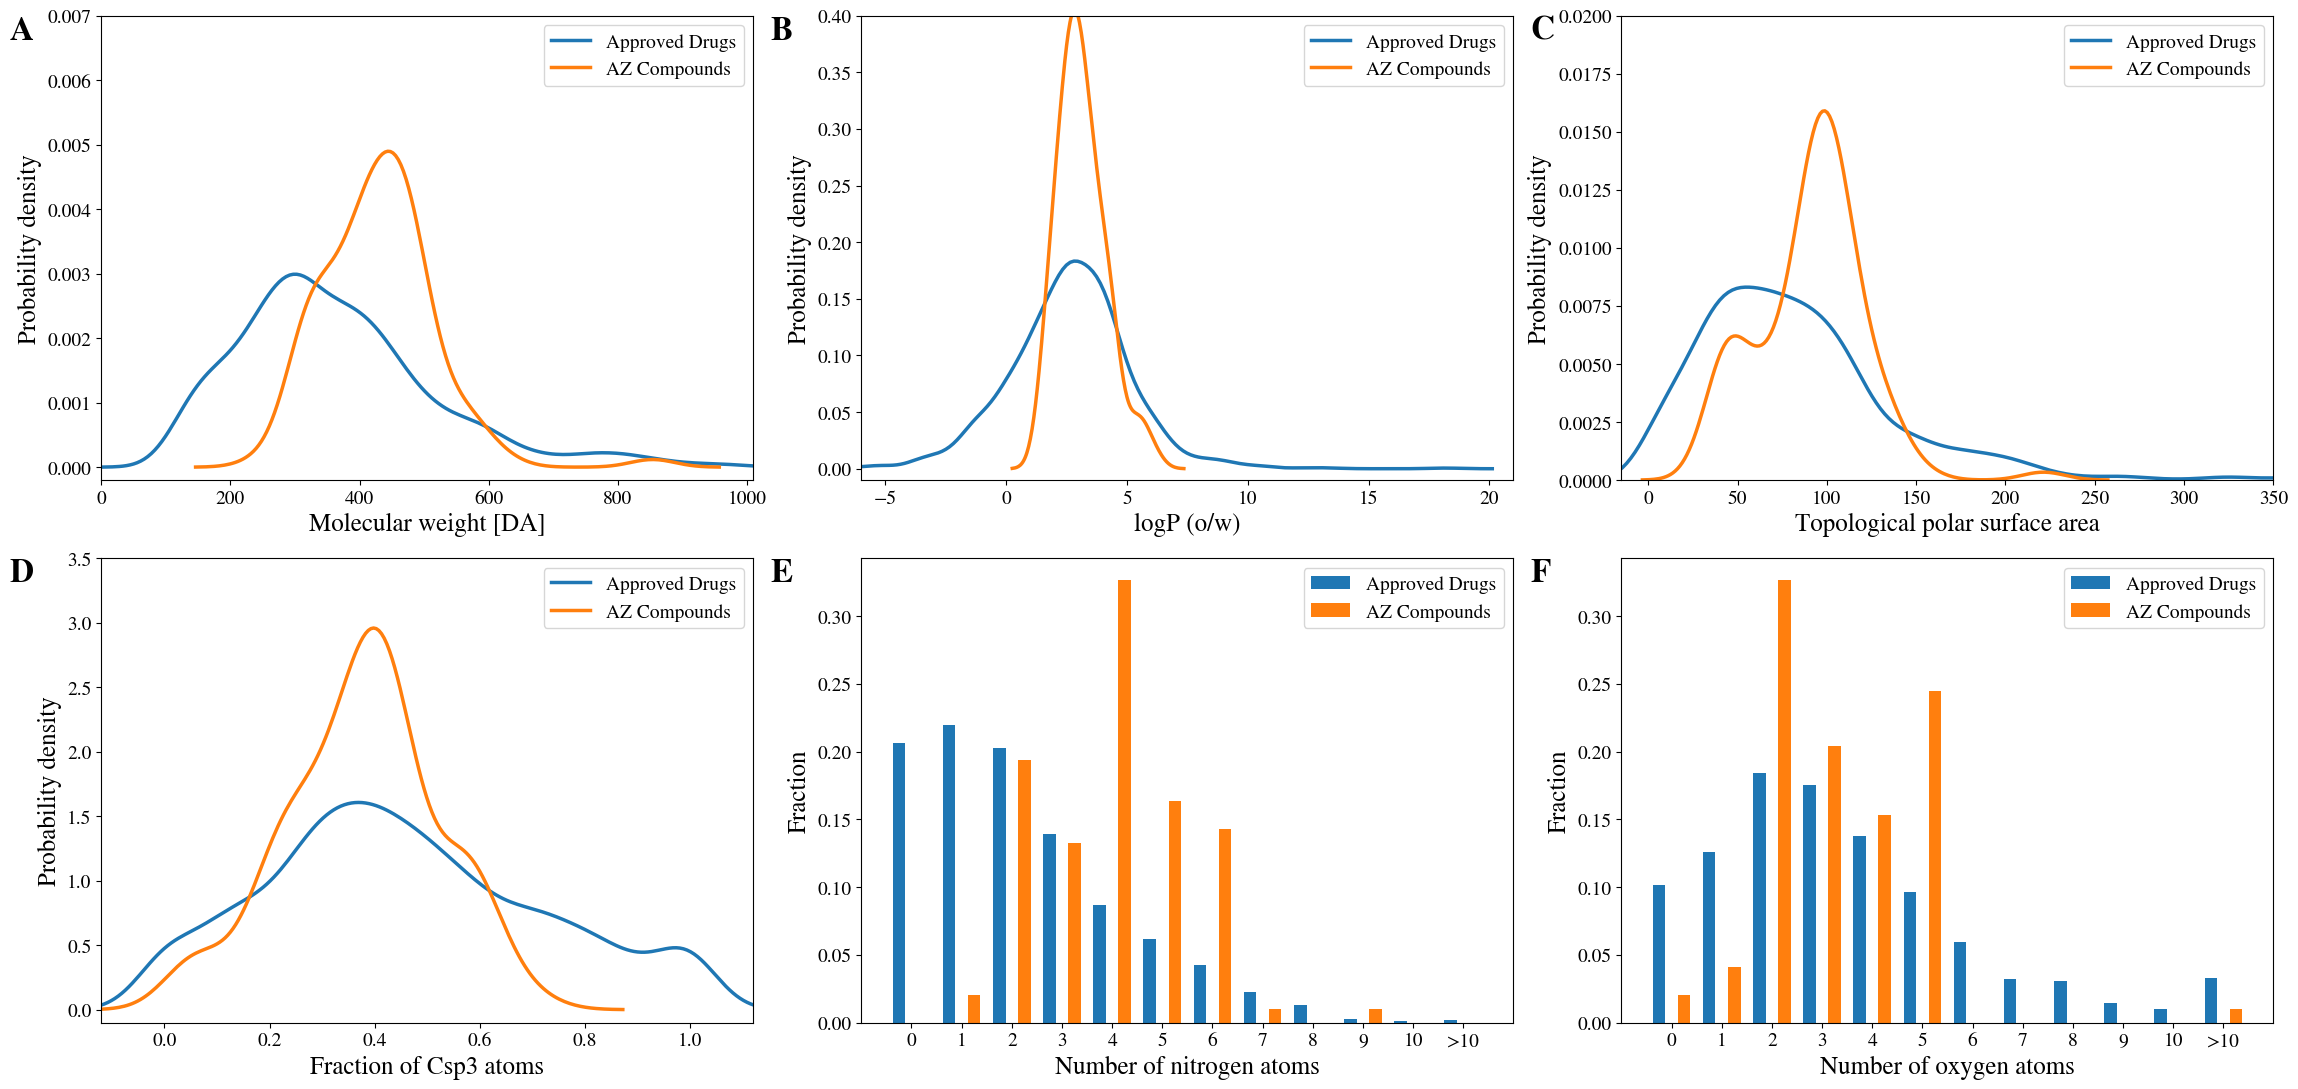

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Adjusting the font and figure size
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.figsize'] = (23, 11)  # Size of the entire figure

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3)

# Add subplot labels A-F
for ax, label in zip(axs.flat, ['A', 'B', 'C', 'D', 'E', 'F']):
    ax.text(-0.14, 1, label, transform=ax.transAxes,
            fontsize=24, fontweight='bold', va='top')

# Plot 1: MW
propertyColumn = 'MW'
sns.kdeplot(drugs_df[propertyColumn], label='Approved Drugs', fill=False, linewidth=2.5, ax=axs[0, 0])
sns.kdeplot(az_public_df[propertyColumn], label='AZ Compounds', fill=False, linewidth=2.5, ax=axs[0, 0])
axs[0, 0].set_xlabel(labelDict[propertyColumn], fontsize=18)
axs[0, 0].set_ylabel('Probability density', fontsize=18)
axs[0, 0].legend(fontsize=14)
axs[0, 0].tick_params(labelsize=14)
axs[0, 0].set_xlim(left=0, right=1010)
axs[0, 0].set_ylim(bottom=-0.0002, top=0.0070)

# Plot 2: logP
propertyColumn = 'logP'
sns.kdeplot(drugs_df[propertyColumn], label='Approved Drugs', fill=False, linewidth=2.5, ax=axs[0, 1])
sns.kdeplot(az_public_df[propertyColumn], label='AZ Compounds', fill=False, linewidth=2.5, ax=axs[0, 1])
axs[0, 1].set_xlabel(labelDict[propertyColumn], fontsize=18)
axs[0, 1].set_ylabel('Probability density', fontsize=18)
axs[0, 1].legend(fontsize=14)
axs[0, 1].tick_params(labelsize=14)
axs[0, 1].set_xlim(left=-6, right=21)
axs[0, 1].set_ylim(bottom=-0.01, top=0.4)

# Plot 3: TPSA
propertyColumn = 'TPSA'
sns.kdeplot(drugs_df[propertyColumn], label='Approved Drugs', fill=False, linewidth=2.5, ax=axs[0, 2])
sns.kdeplot(az_public_df[propertyColumn], label='AZ Compounds', fill=False, linewidth=2.5, ax=axs[0, 2])
axs[0, 2].set_xlabel(labelDict[propertyColumn], fontsize=18)
axs[0, 2].set_ylabel('Probability density', fontsize=18)
axs[0, 2].legend(fontsize=14)
axs[0, 2].tick_params(labelsize=14)
axs[0, 2].set_xlim(left=-15, right=350)
axs[0, 2].set_ylim(bottom=0, top=0.02)

# Plot 4: frac_csp3
propertyColumn = 'frac_csp3'
sns.kdeplot(drugs_df[propertyColumn], label='Approved Drugs', fill=False, linewidth=2.5, ax=axs[1, 0])
sns.kdeplot(az_public_df[propertyColumn], label='AZ Compounds', fill=False, linewidth=2.5, ax=axs[1, 0])
axs[1, 0].set_xlabel(labelDict[propertyColumn], fontsize=18)
axs[1, 0].set_ylabel('Probability density', fontsize=18)
axs[1, 0].legend(fontsize=14)
axs[1, 0].tick_params(labelsize=14)
axs[1, 0].set_xlim(left=-0.12, right=1.12)
axs[1, 0].set_ylim(bottom=-0.1, top=3.5)

# Plot 5: N
propertyColumn = 'N'

# Custom histogram function for Plot 6
def custom_histogram(data, max_value=10):
    counts = np.zeros(max_value + 2)
    for value in data:
        if value > max_value:
            counts[-1] += 1
        else:
            counts[value] += 1
    return counts

# Compute the custom histograms
drugs_counts = custom_histogram(drugs_df[propertyColumn])
AZ_public_counts = custom_histogram(az_public_df[propertyColumn])

# Convert counts to fractions
drugs_fractions = drugs_counts / len(drugs_df)
AZ_public_fractions = AZ_public_counts / len(az_public_df)

x_labels = list(map(str, range(11))) + ['>10']
x_indices = np.arange(len(x_labels))

width = 0.25

axs[1, 1].bar(x_indices - width, drugs_fractions, width=width, label='Approved Drugs')
axs[1, 1].bar(x_indices + width, AZ_public_fractions, width=width, label='AZ Compounds')

# Setting x-axis labels and limits
axs[1, 1].set_xticks(x_indices)
axs[1, 1].set_xticklabels(x_labels)
axs[1, 1].tick_params(labelsize=14)
axs[1, 1].set_xlim(left=-1, right=len(x_labels))

# Labels and legend
axs[1, 1].set_ylabel('Fraction', fontsize=18)
axs[1, 1].set_xlabel(labelDict[propertyColumn], fontsize=18)
axs[1, 1].legend(fontsize=14)

# Plot 6: O
propertyColumn = 'O'

# Compute the custom histograms
drugs_counts = custom_histogram(drugs_df[propertyColumn])
AZ_public_counts = custom_histogram(az_public_df[propertyColumn])

# Convert counts to fractions
drugs_fractions = drugs_counts / len(drugs_df)
AZ_public_fractions = AZ_public_counts / len(az_public_df)

x_labels = list(map(str, range(11))) + ['>10']
x_indices = np.arange(len(x_labels))

axs[1, 2].bar(x_indices - width, drugs_fractions, width=width, label='Approved Drugs')
axs[1, 2].bar(x_indices + width, AZ_public_fractions, width=width, label='AZ Compounds')

# Setting x-axis labels and limits
axs[1, 2].set_xticks(x_indices)
axs[1, 2].set_xticklabels(x_labels)
axs[1, 2].tick_params(labelsize=14)
axs[1, 2].set_xlim(left=-1, right=len(x_labels))

# Labels and legend
axs[1, 2].set_ylabel('Fraction', fontsize=18)
axs[1, 2].set_xlabel(labelDict[propertyColumn], fontsize=18)
axs[1, 2].legend(fontsize=14)

# Adjust the layout
plt.tight_layout()

# Show the final figure with all subplots
plt.show()


## Similarity of compounds

In [39]:
# Import required RDKit modules for chemical fingerprints and similarity calculations
from rdkit.Chem import AllChem  # For Morgan fingerprints
from rdkit import DataStructs   # For similarity calculations

def get_df_name(df):
    """Get the variable name of a DataFrame object in the global namespace
    
    Args:
        df: pandas DataFrame object
        
    Returns:
        str: Name of the DataFrame variable
    """
    name = [x for x in globals() if globals()[x] is df][0]
    return name

def similarity_between(df1, df2):
    """Calculate chemical similarity between compounds in two DataFrames
    
    For each compound in df2, finds the most similar compound in df1 using
    Morgan fingerprints and Tanimoto similarity.
    
    Args:
        df1: Reference DataFrame containing SMILES and mol objects
        df2: Query DataFrame to find matches for
        
    Returns:
        Modifies df2 in place, adding columns for:
        - Similarity score to closest match in df1 
        - SMILES of closest match in df1
    """
    # Get SMILES strings and calculate Morgan fingerprints for reference compounds
    df1_smis = list(df1.smi_noStereo)
    df1_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) 
               for m in list(df1.mol_noStereo)]
    
    def closest_compound(row):
        """Find closest matching compound from df1 for a single row in df2"""
        # Calculate fingerprint for query compound
        fp = AllChem.GetMorganFingerprintAsBitVect(row.mol_noStereo, 2, nBits=2048)
        
        # Calculate Tanimoto similarities to all reference compounds
        similarities = DataStructs.BulkTanimotoSimilarity(fp, df1_fps)
        
        # Get highest similarity score and corresponding compound
        max_sim = max(similarities)
        max_idx = similarities.index(max_sim)
        
        return [max_sim, df1_smis[max_idx]]
    
    # Get name of reference DataFrame for column labels
    name = get_df_name(df1)
    
    # Calculate similarities and add results to df2
    df2['closest_compound_inf'] = df2.apply(lambda row: closest_compound(row), axis=1)
    df2[['similairty_'+name, 'closest_'+name+'_smiles']] = df2.closest_compound_inf.to_list()
    del df2['closest_compound_inf']  # Remove temporary column

In [40]:
az_public_df['mol_noStereo'] = az_public_df['smi_noStereo'].map(Chem.MolFromSmiles)
drugs_df['mol_noStereo'] = drugs_df['smi_noStereo'].map(Chem.MolFromSmiles)


# Calculate similarity between approved drugs and AZ public compounds  
# This will add two columns to az_public_df:
# - similairty_drugs_df: Tanimoto similarity to closest approved drug
# - closest_drugs_df_smiles: SMILES of closest approved drug
similarity_between(drugs_df,az_public_df)

In [41]:
az_public_drugs_sim_list = sorted(list(az_public_df.similairty_drugs_df),reverse=True)
az_public_drugs_sim_list[:20]  # Show 20 highest similarity scores

[1.0,
 1.0,
 1.0,
 0.47368421052631576,
 0.4578313253012048,
 0.38333333333333336,
 0.3786407766990291,
 0.3709677419354839,
 0.3373493975903614,
 0.3333333333333333,
 0.3246753246753247,
 0.3188405797101449,
 0.3076923076923077,
 0.30612244897959184,
 0.29850746268656714,
 0.2978723404255319,
 0.29508196721311475,
 0.29310344827586204,
 0.29292929292929293,
 0.288135593220339]

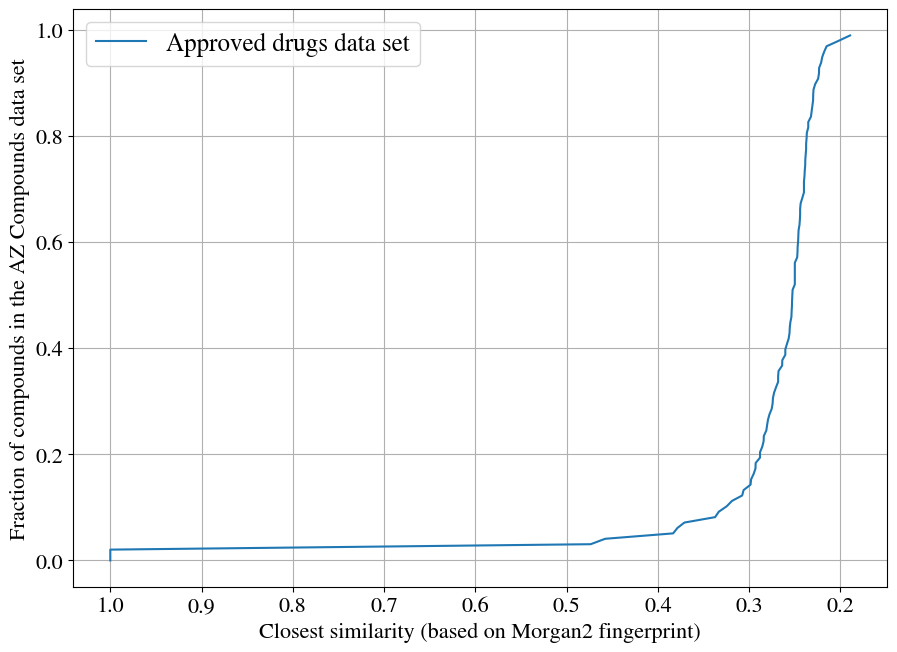

In [42]:
import numpy as np

# Set font style for plot
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.figsize'] = [10.5, 7.5] 

# Plot similarity distributions for both datasets
# X-axis: Sorted similarity scores (high to low)
# Y-axis: Cumulative fraction of compounds
plt.plot(sorted(az_public_drugs_sim_list, reverse=True),
         np.array(list(range(len(az_public_df))))/len(az_public_df),
         label='Approved drugs data set')


# Add legend and customize appearance
plt.legend(fontsize=18, loc='upper left')
plt.gca().invert_xaxis()  # Invert x-axis to show highest similarities on left
plt.tick_params(labelsize=16)

# Add axis labels
plt.xlabel('Closest similarity (based on Morgan2 fingerprint)', fontsize=16)
plt.ylabel('Fraction of compounds in the AZ Compounds data set', fontsize=16)

plt.grid(True)
plt.show()

### similarity within a data set

In [43]:
from tqdm.auto import tqdm

def get_closest_similarity_within_df(df):
    """
    Calculate the highest Tanimoto similarity between each molecule and all other molecules in the dataframe.
    
    Args:
        df (pd.DataFrame): DataFrame containing molecular information with columns:
            - mol_noStereo: RDKit molecule objects without stereochemistry
            - smi_noStereo: SMILES strings without stereochemistry
    
    Returns:
        list: List of maximum Tanimoto similarities for each molecule
    
    Notes:
        - Uses Morgan fingerprints (radius=2, 2048 bits) for similarity calculation
        - Excludes self-comparisons by dropping current molecule
        - Uses bulk similarity calculation for efficiency
    """
    max_s_list = []
    for i in tqdm(range(0, len(df))):
        # Generate fingerprint for current molecule
        fp = AllChem.GetMorganFingerprintAsBitVect(df.iloc[i].mol_noStereo, 2, nBits=2048)
        
        # Remove current molecule to avoid self-comparison
        df1 = df.drop(df.index[i])
        
        # Generate fingerprints for all other molecules
        df1_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) 
                  for m in list(df1.mol_noStereo)]
        
        # Calculate similarities and get maximum
        similarities = DataStructs.BulkTanimotoSimilarity(fp, df1_fps)
        max_s_list.append(max(similarities))

    return max_s_list

In [44]:
az_public_internal_sim_list = get_closest_similarity_within_df(az_public_df)
drugs_internal_sim_list = get_closest_similarity_within_df(drugs_df)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/2179 [00:00<?, ?it/s]

In [45]:
# Calculate the percentage of compounds in AZ dataset with similarity > 0.6
az_sim_above_06 = sum(1 for sim in az_public_internal_sim_list if sim > 0.6)
az_sim_percentage = (az_sim_above_06 / len(az_public_internal_sim_list)) * 100

print(f"Number of AZ compounds with similarity > 0.6: {az_sim_above_06}")
print(f"Percentage of AZ compounds with similarity > 0.6: {az_sim_percentage:.2f}%")

drugs_sim_above_06 = sum(1 for sim in drugs_internal_sim_list if sim > 0.6)
drugs_sim_percentage = (drugs_sim_above_06 / len(drugs_internal_sim_list)) * 100

print(f"Number of Approved Drugs compounds with similarity > 0.6: {drugs_sim_above_06}")
print(f"Percentage of Approved Drugs compounds with similarity > 0.6: {drugs_sim_percentage:.2f}%")


Number of AZ compounds with similarity > 0.6: 61
Percentage of AZ compounds with similarity > 0.6: 62.24%
Number of Approved Drugs compounds with similarity > 0.6: 834
Percentage of Approved Drugs compounds with similarity > 0.6: 38.27%


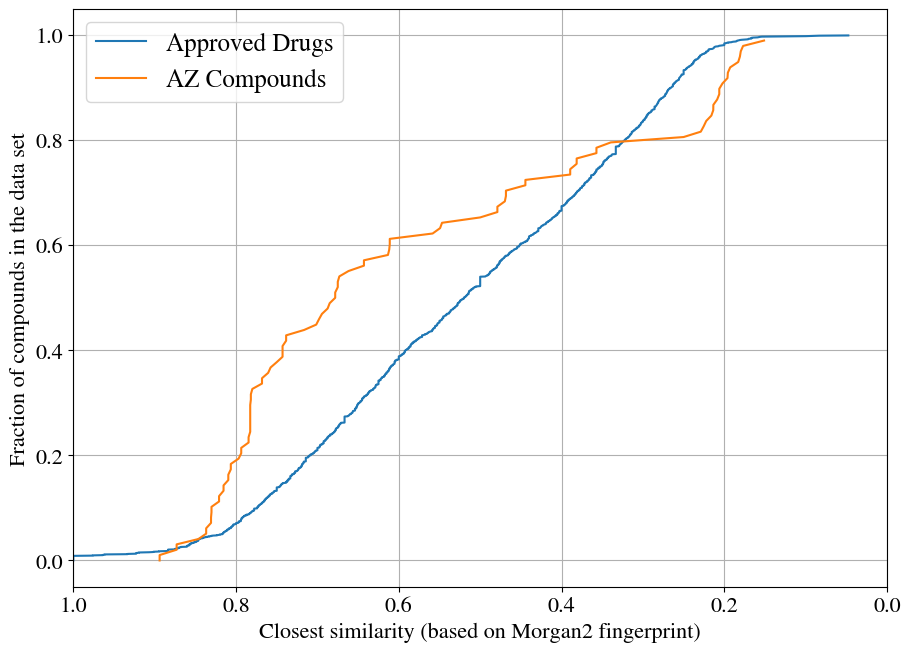

In [46]:
plt.figure(figsize=(10.5,7.5))

plt.plot(sorted(drugs_internal_sim_list,reverse=True),
         np.array(list(range(len(drugs_internal_sim_list))))/len(drugs_internal_sim_list))


plt.plot(sorted(az_public_internal_sim_list,reverse=True),
         np.array(list(range(len(az_public_internal_sim_list))))/len(az_public_internal_sim_list))
    
plt.legend(['Approved Drugs','AZ Compounds'], fontsize=18,loc='upper left')
# plt.title('Similarity within data set')
plt.tick_params(labelsize=16)
plt.xlabel('Closest similarity (based on Morgan2 fingerprint)',fontsize=16)
plt.ylabel('Fraction of compounds in the data set',fontsize=16)
plt.grid(True)
plt.xlim(1, 0)  # Set x-axis limits from 1 to 0
plt.show()

## Murcko scaffolds

In [47]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_murcko_scaffold_from_mol(mol):
    return Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(mol))

In [48]:
az_public_df['Murcko_scaffold'] = az_public_df.mol_noStereo.map(get_murcko_scaffold_from_mol)
len(az_public_df)

98

In [49]:
len(az_public_df.drop_duplicates('Murcko_scaffold'))

65

In [50]:
az_scaffold_frequency_df = pd.DataFrame(az_public_df.Murcko_scaffold.value_counts()).reset_index()
list(az_scaffold_frequency_df['count'])[:20]

[8, 7, 5, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]

In [51]:
from collections import Counter

Counter(list(az_scaffold_frequency_df['count']))

Counter({1: 50, 2: 9, 3: 2, 8: 1, 7: 1, 5: 1, 4: 1})

In [52]:
drugs_df['Murcko_scaffold'] = drugs_df.mol_noStereo.map(get_murcko_scaffold_from_mol)
len(drugs_df)

2179

In [53]:
drugs_scaffold_frequency_df = pd.DataFrame(drugs_df.Murcko_scaffold.value_counts()).reset_index()
list(drugs_scaffold_frequency_df['count'])[:20]

[210, 185, 31, 26, 16, 16, 12, 11, 10, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8]

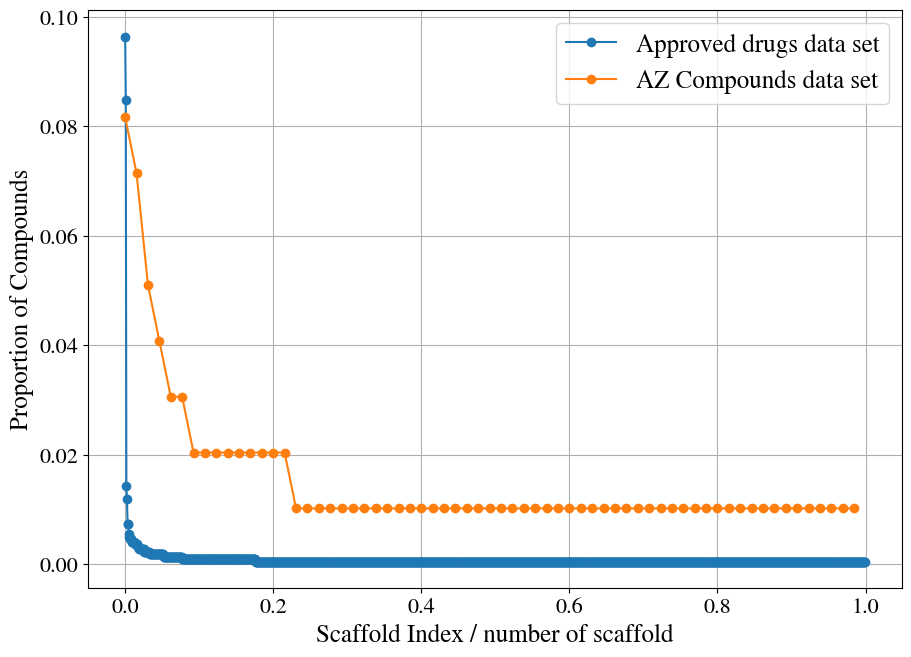

In [54]:
# Normalize the x-axis (scaffold index) as a proportion of the total number of scaffolds
x_drugs = [i / len(drugs_scaffold_frequency_df) for i in range(len(drugs_scaffold_frequency_df))]
x_az = [i / len(az_scaffold_frequency_df) for i in range(len(az_scaffold_frequency_df))]

# Normalize the y-axis (count) as a proportion of the total number of compounds
y_drugs = drugs_scaffold_frequency_df['count'] / drugs_scaffold_frequency_df['count'].sum()
y_az = az_scaffold_frequency_df['count'] / az_scaffold_frequency_df['count'].sum()

# Plotting the data
plt.plot(x_drugs, y_drugs, marker='o', linestyle='-', label='Drugs')
plt.plot(x_az, y_az, marker='o', linestyle='-', label='AZ')

plt.legend(['Approved drugs data set','AZ Compounds data set'], fontsize=18,loc='upper right')
plt.tick_params(labelsize=16)
plt.xlabel('Scaffold Index / number of scaffold',fontsize=18)
plt.ylabel('Proportion of Compounds',fontsize=18)
# plt.title('')
plt.grid(True)
plt.show()

In [55]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform data
label_encoder.fit(list(az_scaffold_frequency_df.Murcko_scaffold))

# Create a custom mapping between strings and labels based on the sequence in original_list
label_mapping = {value: key for key, value in enumerate(list(az_scaffold_frequency_df.Murcko_scaffold), start=1)}

# Initialize LabelEncoder with custom mapping
label_encoder = LabelEncoder()
label_encoder.classes_ = list(label_mapping.keys())
label_encoder.transform = lambda x: [label_mapping[item] for item in x]

# Transform new list using the custom label encoder
az_public_df['scaffold_index'] = label_encoder.transform(list(az_public_df.Murcko_scaffold))

In [56]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform data
label_encoder.fit(list(drugs_scaffold_frequency_df.Murcko_scaffold))

# Create a custom mapping between strings and labels based on the sequence in original_list
label_mapping = {value: key for key, value in enumerate(list(drugs_scaffold_frequency_df.Murcko_scaffold), start=1)}

# Initialize LabelEncoder with custom mapping
label_encoder = LabelEncoder()
label_encoder.classes_ = list(label_mapping.keys())
label_encoder.transform = lambda x: [label_mapping[item] for item in x]

# Transform new list using the custom label encoder
drugs_df['scaffold_index'] = label_encoder.transform(list(drugs_df.Murcko_scaffold))

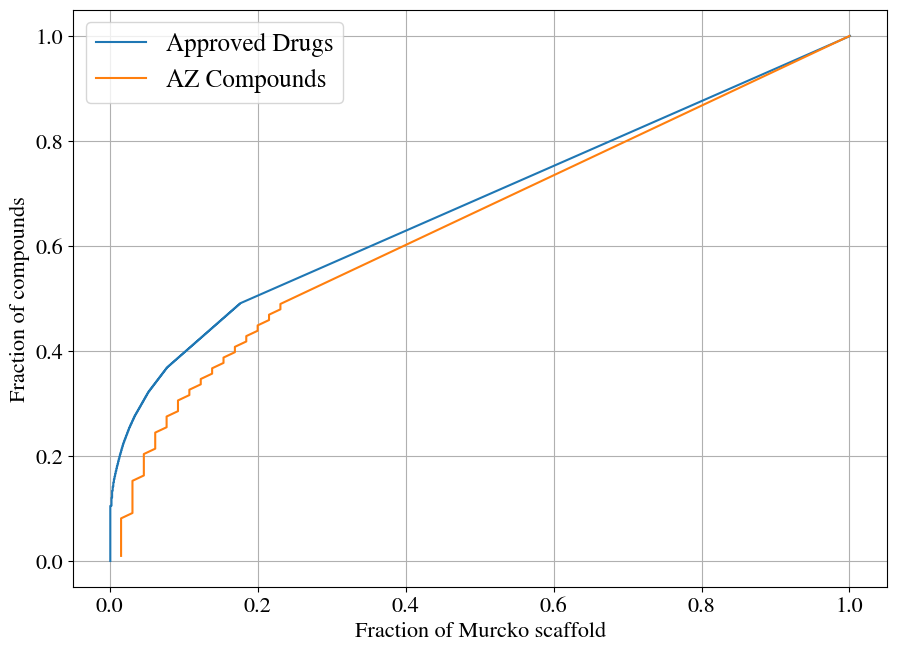

In [57]:
# remove compounds with no Murcko scaffold
drugs_df2 = drugs_df[drugs_df.Murcko_scaffold!='']

plt.plot(np.array(drugs_df2.scaffold_index.sort_values())/len(drugs_df2.scaffold_index.unique()),np.arange(1,len(drugs_df2)+1)/len(drugs_df2))
plt.plot(np.array(az_public_df.scaffold_index.sort_values())/len(az_public_df.scaffold_index.unique()),np.arange(1,len(az_public_df)+1)/len(az_public_df))

# Adding legend and labels
plt.tick_params(labelsize=16)
plt.legend(['Approved Drugs', 'AZ Compounds'], fontsize=18, loc='upper left')
plt.xlabel('Fraction of Murcko scaffold',fontsize=16)
plt.ylabel('Fraction of compounds',fontsize=16)
plt.grid(True)


plt.show()

### scaffold overlap

In [58]:
pd.merge(drugs_scaffold_frequency_df, az_scaffold_frequency_df, how ='inner', on=['Murcko_scaffold'])

,Murcko_scaffold,count_x,count_y
0,c1ccc(CCOC2CCCCC2N2CCCC2)cc1,1,1
1,C1=CC(c2ccccc2)c2cnccc2N1,1,1
2,O=C(CC(NC(=O)c1ccccc1)c1ccccc1)OC1C=C2CC(=O)C3...,1,1


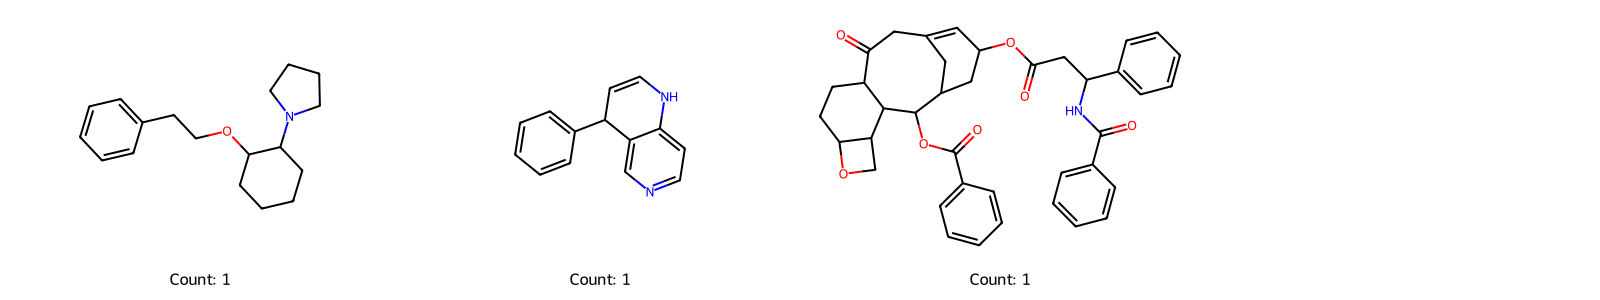

In [59]:
# visualize the overlap scaffolds from drugs and az using a different dataframe name
overlap_scaffolds_drugs_az  = pd.merge(drugs_scaffold_frequency_df, az_scaffold_frequency_df, how ='inner', on=['Murcko_scaffold'])
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold in overlap_scaffolds_drugs_az['Murcko_scaffold']], 
                     molsPerRow=4, 
                     subImgSize=(400,300),
                     legends=[f"Count: {overlap_scaffolds_drugs_az['count_x'].iloc[i]}" for i in range(len(overlap_scaffolds_drugs_az))])

In [60]:
list(overlap_scaffolds_drugs_az.Murcko_scaffold)

['c1ccc(CCOC2CCCCC2N2CCCC2)cc1',
 'C1=CC(c2ccccc2)c2cnccc2N1',
 'O=C(CC(NC(=O)c1ccccc1)c1ccccc1)OC1C=C2CC(=O)C3CCC4OCC4C3C(OC(=O)c3ccccc3)C(C2)C1']

# End